**Title:** Training your first Convolutional Neural Network<br/>
**Author:** Adrian Rosebrock, [PyImageSearch.com](https://www.pyimagesearch.com/)<br/>

This tutorial is meant to be an *introduction* to image classification and deep learning using the [Microsoft Data Science Virtual Machine](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/). We will present all code necessary to run the example, but will only briefly discuss it.

For an in-depth treatment of deep learning and Convolutional Neural Networks, please refer to [*Deep Learning for Computer Vision with Python*](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/).

Let's go ahead and get started.

In [1]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class LeNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
            
		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Using TensorFlow backend.


The `LeNet` class will encapsulate our implementation. The `build` method will then handle constructing the CNN. We also take special care to define the `inputShape` based on whether we are using channels-last ordering (typically used with TensorFlow) or channels-first ordering (which Theano uses).

We then define our first set of `CONV => RELU => POOL` layers. Here we learn 20 convolution filters, each of which are *5x5*. We then apply a ReLU activation followed by *2x2* max-pooling to reduce the spatial dimensions.

A similar process is then used for our second set of `CONV => RELU => POOL` layers, this time learning 50 filters instead of 20.

Our final layer set in the LeNet implementation handles flattening out the volume into a set of fully-connected layers and output predictions.

Let's move on to training our network. First, let's handle our imports and download the MNIST dataset (a collection of 70,000 28x28 grayscale images):

In [2]:
# import the necessary packages
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

# grab the MNIST dataset (if this is your first time using this
# dataset then the 55MB download may take a minute)
print("[INFO] accessing MNIST...")
dataset = datasets.fetch_mldata("MNIST Original")
data = dataset.data

[INFO] accessing MNIST...


Our goal here is to train a Convolutional Neural Network that can recognize each of the handwritten digits, 0-9.

We then need to reshape the `data` matrix based on whether we are using channels-last or channels first-ordering:

In [3]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	data = data.reshape(data.shape[0], 1, 28, 28)

# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	data = data.reshape(data.shape[0], 28, 28, 1)

Create the training and testing split:

In [4]:
# scale the input data to the range [0, 1] and perform a train/test
# split
(trainX, testX, trainY, testY) = train_test_split(data / 255.0,
	dataset.target.astype("int"), test_size=0.25, random_state=42)

And then binarize the labels:

In [5]:
# convert the labels from integers to vectors
le = LabelBinarizer()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

We are now ready to instantiate the `LeNet` class:

In [6]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


Notice how the parameters to `LeNet.build` match the spatial dimensions of the images in the MNIST dataset.

We'll be using the Stochastic Gradient Descent (SGD) optimizer for this task. Using `categorical_crossentropy` is common for multi-class classification problems.

We can now train our network for 20 epochs using a batch size of 128:

In [7]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=128, epochs=20, verbose=1)

[INFO] training network...
Train on 52500 samples, validate on 17500 samples
Epoch 1/20
52500/52500 [==============================] - 8s 159us/step - loss: 1.0553 - acc: 0.7207 - val_loss: 0.5673 - val_acc: 0.8083
Epoch 2/20
52500/52500 [==============================] - 7s 124us/step - loss: 0.2861 - acc: 0.9146 - val_loss: 0.2793 - val_acc: 0.9150
Epoch 3/20
52500/52500 [==============================] - 7s 126us/step - loss: 0.2059 - acc: 0.9385 - val_loss: 0.3395 - val_acc: 0.8856
Epoch 4/20
52500/52500 [==============================] - 7s 129us/step - loss: 0.1626 - acc: 0.9519 - val_loss: 0.3899 - val_acc: 0.8765
Epoch 5/20
52500/52500 [==============================] - 7s 126us/step - loss: 0.1348 - acc: 0.9596 - val_loss: 0.1283 - val_acc: 0.9617
Epoch 6/20
52500/52500 [==============================] - 7s 127us/step - loss: 0.1148 - acc: 0.9659 - val_loss: 0.1775 - val_acc: 0.9444
Epoch 7/20
52500/52500 [==============================] - 7s 130us/step - loss: 0.1012 - acc: 0

And then evaluate it on our testing set:

In [8]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in le.classes_]))

[INFO] evaluating network...
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1677
          1       0.98      1.00      0.99      1935
          2       0.99      0.98      0.98      1767
          3       0.98      0.98      0.98      1766
          4       0.98      0.99      0.99      1691
          5       0.96      0.99      0.97      1653
          6       1.00      0.98      0.99      1754
          7       0.98      0.99      0.98      1846
          8       0.99      0.96      0.97      1702
          9       0.98      0.96      0.97      1709

avg / total       0.98      0.98      0.98     17500



Finally, let's plot the training loss and accuracy:

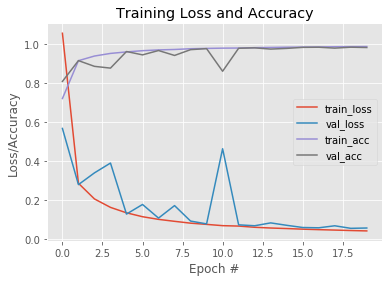

In [9]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

I hope you enjoyed this tutorial!

If you're interested in studying deep learning applied to computer visions in more depth, be sure to take a look at my book, [*Deep Learning for Computer Vision with Python*](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/).